In [1]:
import copy
import warnings
from functools import partial

import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import LambdaLR

In [2]:
def _get_linear_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int, num_training_steps: int):
    if current_step < num_warmup_steps:
        return float(current_step) / float(max(1, num_warmup_steps))
    return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))


def _get_linear_schedule_with_warmup_from_init_to_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, init_lr: float, final_lr: float
):
    if current_step < num_warmup_steps:
        return (final_lr - init_lr) / max(1.0, num_warmup_steps) * float(current_step) + init_lr
    return max(
        0.0, final_lr * (1 - float(current_step - num_warmup_steps) / max(1, num_training_steps - num_warmup_steps))
    )


def get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps, last_epoch=-1, init_lrs=None, lrs_after_warmup=None
):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """
    if lrs_after_warmup is None:
        lr_lambdas = partial(
            _get_linear_schedule_with_warmup_lr_lambda,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps,
        )
    else:
        if init_lrs is None:
            init_lrs_per_group = [copy.deepcopy(param_group["lr"]) for param_group in optimizer.param_groups]
        elif not isinstance(init_lrs, (list, tuple)):
            init_lrs_per_group = [init_lrs for _ in optimizer.param_groups]
        else:
            if len(init_lrs) != len(optimizer.param_groups):
                raise ValueError(
                    f"Expected {len(optimizer.param_groups)} initial learning rates, but got {len(init_lrs)}"
                )
            init_lrs_per_group = init_lrs
        if not isinstance(lrs_after_warmup, (list, tuple)):
            lrs_after_warmup = [lrs_after_warmup for _ in optimizer.param_groups]
        else:
            if len(lrs_after_warmup) != len(init_lrs_per_group):
                raise ValueError(
                    f"Expected {len(init_lrs_per_group)} lrs to reach after warmup, but got {len(lrs_after_warmup)}"
                )
        warnings.warn(
            "Setting the learning rate of every param group to 1.0. This is done to simplify the learning rate scheduling code.",
            UserWarning,
        )
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1.0
        lr_lambdas = [
            (
                partial(
                    _get_linear_schedule_with_warmup_from_init_to_warmup_lr_lambda,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=num_training_steps,
                    init_lr=init_lr,
                    final_lr=final_lr,
                )
            )
            for init_lr, final_lr in zip(init_lrs_per_group, lrs_after_warmup)
        ]
    return LambdaLR(optimizer, lr_lambdas, last_epoch)

In [3]:
m = torch.nn.Linear(20, 1)

In [4]:
lr = 0.4
o = torch.optim.Adam(m.parameters(), lr=lr)

/home/fbelotti/miniconda3/envs/turl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ep = 10
ds = 100
bs = 5
warm = 0
spe = ds // bs
total_steps = ep * spe
warm_steps = warm * spe
lrs = []

In [6]:
scheduler = get_linear_schedule_with_warmup(
    o, num_warmup_steps=warm_steps, num_training_steps=total_steps, init_lrs=lr, lrs_after_warmup=lr
)

/tmp/ipykernel_1081524/89219666.py:61: UserWarning: Setting the learning rate of every param group to 1.0. This is done to simplify the learning rate scheduling code.
  warnings.warn("Setting the learning rate of every param group to 1.0. This is done to simplify the learning rate scheduling code.", UserWarning)


In [7]:
for s in range(total_steps):
    print(",".join(str(group["lr"]) for group in o.param_groups))
    o.step()
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()

0.4
0.398
0.396
0.394
0.392
0.39
0.388
0.386
0.384
0.382
0.38
0.378
0.376
0.37400000000000005
0.372
0.37000000000000005
0.36800000000000005
0.36600000000000005
0.36400000000000005
0.36200000000000004
0.36000000000000004
0.35800000000000004
0.35600000000000004
0.35400000000000004
0.35200000000000004
0.35000000000000003
0.34800000000000003
0.34600000000000003
0.34400000000000003
0.342
0.34
0.338
0.336
0.334
0.332
0.33
0.32800000000000007
0.326
0.32400000000000007
0.322
0.32000000000000006
0.31800000000000006
0.31600000000000006
0.31400000000000006
0.31200000000000006
0.31000000000000005
0.30800000000000005
0.30600000000000005
0.30400000000000005
0.30200000000000005
0.30000000000000004
0.298
0.296
0.294
0.292
0.29
0.288
0.28600000000000003
0.284
0.28200000000000003
0.27999999999999997
0.278
0.27599999999999997
0.274
0.27199999999999996
0.27
0.26799999999999996
0.266
0.26399999999999996
0.262
0.26
0.258
0.256
0.254
0.252
0.25
0.248
0.246
0.244
0.242
0.24
0.238
0.23600000000000004
0.2339999

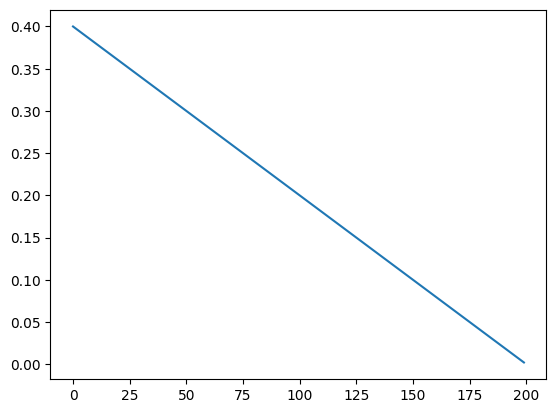

In [8]:
plt.plot(lrs)